### First read data from the disk

In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import copy
%matplotlib inline

def load_training_data(directory):
    df_raw = pd.read_csv('./'+directory+'/driving_log.csv')
    df_raw.columns = ['center','left','right','steering','throttle','brake','speed']

    directory_series = np.empty( len(df_raw), dtype=object)
    directory_series[:] = directory
    df_raw['directory'] = pd.Series( directory_series, index=df_raw.index)
    return df_raw

def plot_hist(dataframe, bins = 10):  
    steering_cmds = dataframe.as_matrix(columns=['steering'])
    steering_data = steering_cmds[:,0]
    n, bins, patches = plt.hist(steering_data, bins, facecolor='green', alpha=0.75)
    

,center,left,right,steering,throttle,brake,speed,directory
143,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.093364,0.389922,0.0,25.01808,training_data1
144,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.093364,0.370707,0.0,25.22526,training_data1
145,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.083719,0.351492,0.0,25.40843,training_data1
146,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.064429,0.332276,0.0,25.53682,training_data1
147,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.064429,0.332276,0.0,25.68190,training_data1
148,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.016204,0.332276,0.0,25.82681,training_data1
149,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.332276,0.0,25.97039,training_data1
150,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.313061,0.0,26.07602,training_data1
151,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.303454,0.0,26.19024,training_data1
152,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.284239,0.0,26.26752,training_data1


5425
5383
3405
3708


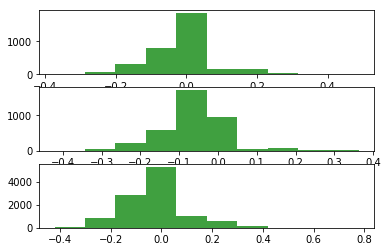

In [2]:
directory1 = 'training_data1'
df_straight = load_training_data(directory1)
directory2 = 'training_data_turn'
df_turn = load_training_data(directory2)

# preprocessing throw all the data where speed is smaller than 2
print (len(df_straight))
print (len(df_turn))

df_turn_preprocess = df_turn[ df_turn.speed > 5 ] 
df_straight_preprocess = df_straight[ ((df_straight.speed > 20.0) & (df_straight.speed < 30.0))] 
#df[ ((df.steering > -0.3) & (df.steering < -0.25) )]

frames = [df_straight, df_turn]
df = pd.concat(frames, ignore_index=True)

print (len(df_straight_preprocess))
print (len(df_turn_preprocess))

plt.subplot(3, 1, 1)
plot_hist(df_straight_preprocess)
plt.subplot(3, 1, 2)
plot_hist(df_turn_preprocess)
plt.subplot(3, 1, 3)
plot_hist(df)


In [3]:
# spllit train validation 
# split df_merge into training and validation set
msk = np.random.rand(len(df)) < 0.8
train_samples = df[msk]
validation_samples = df[~msk]
print ('training n %d', len(train_samples))
print ('validation n %d', len(validation_samples))


training n %d 8700
validation n %d 2108


In [ ]:
df_merge = df
for i in range(len(bins)-1):
    df_sub = df.loc[lambda df: (df.steering >= bins[i]) , :].copy()
    df_sub_ =  df_sub.loc[lambda df: (df.steering < bins[i+1]) , :].copy()
    data_frames = [df_merge, df_sub_]   
    duplicate = 2000/n[i]
    # print duplicate
    for j in range( int(duplicate) ):
        df_merge = pd.concat(data_frames, ignore_index=True)
        data_frames = [df_merge, df_sub_]
steering_cmds = df_merge.as_matrix(columns=['steering'])
steering_data = steering_cmds[:,0]

#plt.subplot(3, 1, 2)
#n, bins, patches = plt.hist(steering_data, 10, facecolor='blue', alpha=0.75)    

# split df_merge into training and validation set
msk = np.random.rand(len(df_merge)) < 0.8
train_samples = df_merge[msk]
validation_samples = df_merge[~msk]
print ('training n %d', len(train_samples))
print ('validation n %d', len(validation_samples))


In [ ]:
#df.steering < 0.4 &  > -0.4
df_inspect = df[ ((df.steering > -0.3) & (df.steering < -0.25) )]
#df.loc[lambda df: df.steering < 0.4 and df.steering > -0.4 , :]
print (len(df_inspect))



    
    

In [ ]:
fig = plt.figure(figsize = (5,5*58))
index = 0
for row_index, series in df_inspect.iterrows():
    name = './'+directory+'/IMG/'+series.center.split('/')[-1]
    image = cv2.imread(name)
    index+=1
    plt.subplot(len(df_inspect), 1, index)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    

In [ ]:
samples = train_samples
num_samples = len(samples)
batch_size = 32
print (num_samples)
df_batch_samples = samples[0:64]
df_batch_samples.reset_index(drop=True)
df_batch_samples
for row_index, series in df_batch_samples.iterrows():
    pass

#for offset in range(0, num_samples, batch_size):
#    pass
#for offset in range(0, num_samples, batch_size):
#    df_batch_samples = samples[offset:offset+batch_size]
#    for row_index, series in df_batch_samples:
#                name = './IMG/'+series.center.split('/')[-1]


In [5]:
import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        # shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            df_batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for row_index, series in df_batch_samples.iterrows():
                name = './'+ series.directory+'/IMG/'+series.center.split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(series.steering)
                images.append(center_image)
                angles.append(center_angle)
            
                left_name = './'+ series.directory+'/IMG/'+series.left.split('/')[-1]
                left_image = cv2.imread(left_name)
                left_angle = float(series.steering) + 0.1
                images.append(left_image)
                angles.append(left_angle)
                
                right_name = './'+ series.directory+'/IMG/'+series.right.split('/')[-1]
                right_image = cv2.imread(right_name)
                right_angle = float(series.steering) - 0.1
                images.append(right_image)
                angles.append(right_angle)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
           
            yield sklearn.utils.shuffle(X_train, y_train)
            #return sklearn.utils.shuffle(X_train, y_train)


            
# compile and train the model using the generator function

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)



### Visualize training data

In [ ]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

(X_training, y_train) =  next(train_generator)

random_image = random.randint(0 , X_training.shape[0])   
#plt.figure( figsize =(100,100))
plt.subplot(3, 1, 1)
plt.imshow( cv2.cvtColor(X_training[random_image], cv2.COLOR_BGR2RGB) )
#plt.subplot(3, 1, 2)
#plt.imshow( cv2.cvtColor(X_training_left[random_image], cv2.COLOR_BGR2RGB) )
#plt.subplot(3, 1, 3)
#plt.imshow( cv2.cvtColor(X_training_right[random_image], cv2.COLOR_BGR2RGB) )


In [ ]:
## use left and right image to train on non zero datas 
df.loc[lambda df: df.steering != 0, :]



### Data augmentation

In [ ]:
X_training_flip = np.zeros([y_train_initial_aug.shape[0], 160 , 320 , 3 ], dtype=np.uint8)
for i in range(y_train_initial_aug.shape[0]):
    X_training_flip[i] =  np.fliplr(X_train_initial_aug[i])
y_train_flip = -y_train_initial_aug


In [ ]:
y_train.shape

In [ ]:
# stack training data
X_training =  np.vstack( (X_train_initial_aug,X_training_flip) )
y_train =  np.concatenate( (y_train_initial_aug, y_train_flip))

In [ ]:
df

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense , Lambda, MaxPooling2D, Dropout,Cropping2D

i_shape = (160, 320,3)

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=i_shape ))
model.add(Cropping2D(cropping=((60,25), (0,0)), input_shape=(160,320,3)))

# conv_net
model.add(Conv2D( 6, 5, 5, activation='relu' ))
model.add(Conv2D( 6, 5, 5,  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
########################################################################
# conv_net
model.add(Conv2D(16, 3, 3, activation='relu'))
model.add(Conv2D(16, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#########################################################################
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')
#model.fit(X_training, y_train, validation_split = 0.2, shuffle=True)
model.fit_generator(train_generator, samples_per_epoch= 3*len(train_samples), validation_data=validation_generator, nb_val_samples=3*len(validation_samples), nb_epoch=5)
model.save('first_model.h5')




Epoch 1/5
  480/26100 [..............................] - ETA: 1023s - loss: 0.0236

KeyboardInterrupt: 